coin_image max 255
coin_image min 0
pencil_image max 247
pencil_image min 0


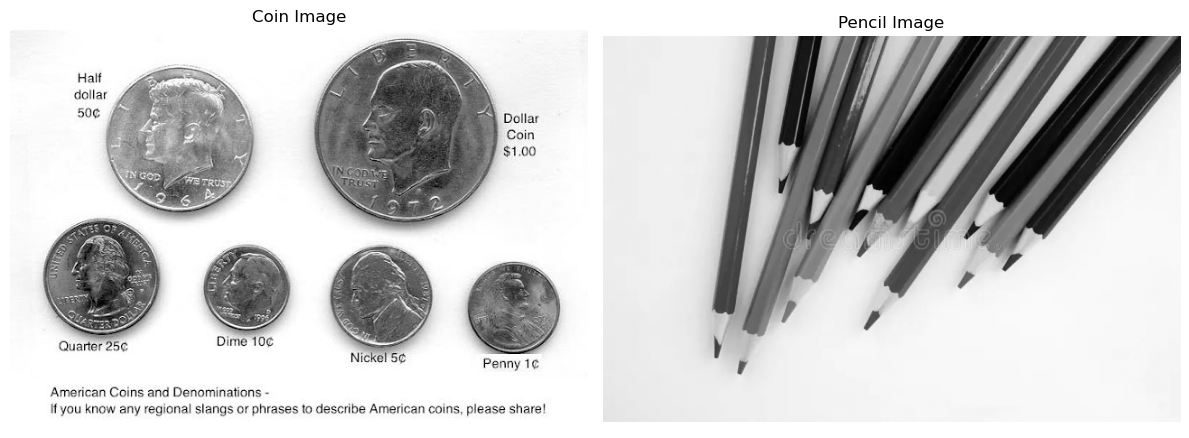

In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
# Load and convert images to grayscale
coin_image = Image.open("coin_image.jpg").convert("L")
pencil_image = Image.open("pencils_image.jpg").convert("L")

# Convert the images to NumPy arrays
coin_image_array = np.array(coin_image, dtype=np.uint8)
pencil_image_array = np.array(pencil_image, dtype=np.uint8)

# Print min and max values for coin image
print("coin_image max", coin_image_array.max())
print("coin_image min", coin_image_array.min())

print("pencil_image max", pencil_image_array.max())
print("pencil_image min", pencil_image_array.min())

# Create a figure with 1 row and 2 columns for the images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image with a title on top
axs[0].imshow(coin_image_array, cmap='gray')
axs[0].set_title("Coin Image")
axs[0].axis('off')  # Turn off axis labels

# Display the second image with a title on top
axs[1].imshow(pencil_image_array, cmap='gray')
axs[1].set_title("Pencil Image")
axs[1].axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


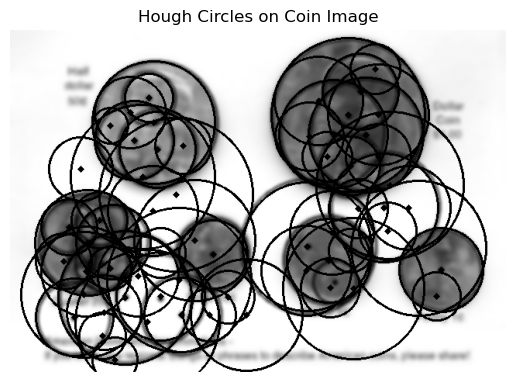

In [70]:
# Performed the follwong steps:
# 1. Gaussian Blur to reduce noise
# 2. Hough Transform to detect circles

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Apply Gaussian Blur to reduce noise
coin_image_array = cv2.GaussianBlur(coin_image_array, (9, 9), 2)

# Detect circles using Hough Transform
circles = cv2.HoughCircles(coin_image_array, 
                           cv2.HOUGH_GRADIENT, 
                           dp=1.2, 
                           minDist=30,
                           param1=100, 
                           param2=30, 
                           minRadius=20, 
                           maxRadius=100)
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        cv2.circle(coin_image_array, center, 2, (0, 255, 0), 3)  # Center
        cv2.circle(coin_image_array, center, radius, (0, 0, 255), 2)  # Perimeter

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(cv2.merge([coin_image_array] * 3), cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.title("Hough Circles on Coin Image")
plt.axis("off")
plt.show()

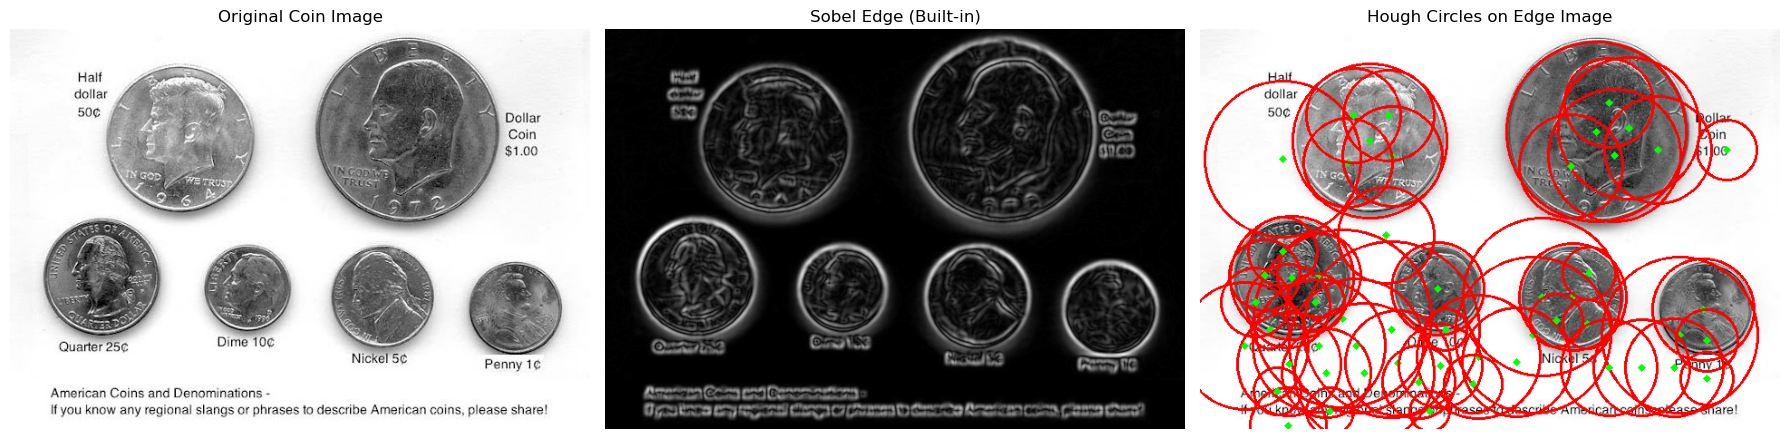

In [79]:
# Performed the follwong steps:
# 1. Gaussian Blur to reduce noise
# 2. Sobel edge detection
# 3. Binary thresholding
# 4. Hough Transform to detect circles

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load and Prepare the Image ---
coin_image = Image.open("coin_image.jpg").convert("L")
coin_image_array = np.array(coin_image, dtype=np.uint8)

# Optionally, apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(coin_image_array, (9, 9), 2)

# --- Built-in Sobel Edge Detection ---
# Compute the Sobel gradients in X and Y directions.
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

# Convert gradients to absolute values and then to uint8.
abs_sobel_x = cv2.convertScaleAbs(sobel_x)
abs_sobel_y = cv2.convertScaleAbs(sobel_y)

# Combine the two gradients to get the overall edge image.
edge_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

# threshold the edge image to create a binary image.
_, edge_thresh = cv2.threshold(edge_image, 50, 255, cv2.THRESH_BINARY)

# --- Hough Circle Detection ---
# Use the thresholded edge image as input for Hough Circle detection.
circles = cv2.HoughCircles(edge_thresh, cv2.HOUGH_GRADIENT,
                           dp=1.2, minDist=30,
                           param1=50, param2=30,
                           minRadius=20, maxRadius=100)

# Create a color copy of the original image for drawing detected circles.
coin_image_color = cv2.cvtColor(coin_image_array, cv2.COLOR_GRAY2BGR)

# If circles are detected, draw them.
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        # Draw the circle center in green.
        cv2.circle(coin_image_color, center, 2, (0, 255, 0), 3)
        # Draw the circle perimeter in red.
        cv2.circle(coin_image_color, center, radius, (0, 0, 255), 2)

# --- Display the Results ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(coin_image_array, cmap="gray")
axs[0].set_title("Original Coin Image")
axs[0].axis("off")

axs[1].imshow(edge_image, cmap="gray")
axs[1].set_title("Sobel Edge (Built-in)")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(coin_image_color, cv2.COLOR_BGR2RGB))
axs[2].set_title("Hough Circles on Edge Image")
axs[2].axis("off")

plt.tight_layout()
plt.show()


[[[186.6      120.600006  83.      ]
  [409.80002  294.6       60.2     ]
  [103.8      274.2       70.880005]
  [432.6      108.600006  99.32    ]
  [551.4      306.6       49.760002]
  [258.6      282.6       47.600002]]]


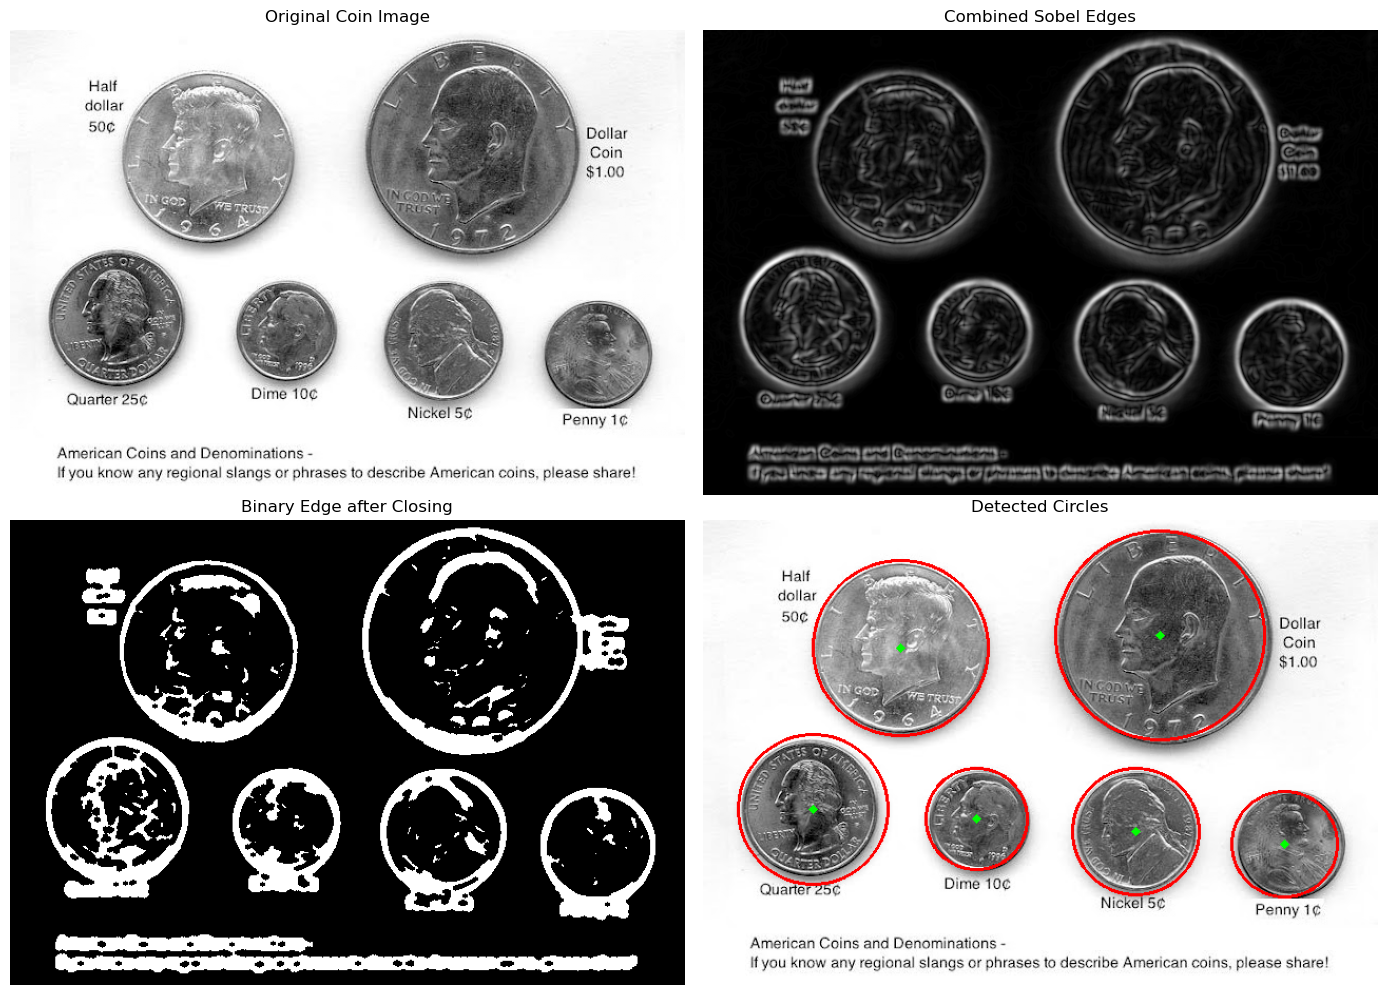

In [115]:
# Performed the follwong steps:
# 1. Gaussian Blur to reduce noise
# 2. Sobel edge detection
# 3. Binary thresholding
# 4. Dilation - Morphological Closing to Fill Gaps in the Edges
# 5. Hough Transform to detect circles

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load and Prepare the Image ---
coin_image = cv2.imread("coin_image.jpg", cv2.IMREAD_GRAYSCALE)
if coin_image is None:
    raise FileNotFoundError("Could not load coin_image.jpg")

# Apply Gaussian Blur to reduce noise.
blurred = cv2.GaussianBlur(coin_image, (9, 9), 2)

# --- Built-in Sobel Edge Detection ---
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
abs_sobel_x = cv2.convertScaleAbs(sobel_x)
abs_sobel_y = cv2.convertScaleAbs(sobel_y)
sobel_combined = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

# --- Binary Thresholding ---
_, binary_edge = cv2.threshold(sobel_combined, 40, 255, cv2.THRESH_BINARY)

# --- Morphological Closing to Fill Gaps in the Edges ---
# A larger elliptical kernel can help join broken edge segments.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed_edges = cv2.morphologyEx(binary_edge, cv2.MORPH_CLOSE, kernel)

# --- Hough Circle Detection ---
# https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html
circles = cv2.HoughCircles(closed_edges, cv2.HOUGH_GRADIENT,
                           dp=1.2, minDist=30,
                           param1=25, param2=50,
                           minRadius=20, maxRadius=100)

print(circles)

# Draw the detected circles on a color copy of the original image.
output_image = cv2.cvtColor(coin_image, cv2.COLOR_GRAY2BGR)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        # Draw the center of the circle in green.
        cv2.circle(output_image, center, 2, (0, 255, 0), 3)
        # Draw the perimeter of the circle in red.
        cv2.circle(output_image, center, radius, (0, 0, 255), 2)

# --- Display the Results ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].imshow(coin_image, cmap="gray")
axs[0, 0].set_title("Original Coin Image")
axs[0, 0].axis("off")

axs[0, 1].imshow(sobel_combined, cmap="gray")
axs[0, 1].set_title("Sobel Edges")
axs[0, 1].axis("off")

axs[1, 0].imshow(closed_edges, cmap="gray")
axs[1, 0].set_title("Binary Edge")
axs[1, 0].axis("off")

axs[1, 1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title("Detected Circles")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()
